In [43]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from PIL import Image, UnidentifiedImageError

# Custom collate function to filter out corrupted images
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

# Custom loader to handle corrupted images
def safe_loader(path):
    try:
        with open(path, "rb") as f:
            img = Image.open(f)
            return img.convert("RGB")
    except UnidentifiedImageError:
        print(f"Skipping corrupted image: {path}")
        return None

#defining the paths to img folders
train_dir = '/home/arnav/Documents/research_project/assignment1/images/train'
test_dir = '/home/arnav/Documents/research_project/assignment1/images/test'
val_dir = '/home/arnav/Documents/research_project/assignment1/images/val'

#Ive used .Compose to group transforms together
transform = transforms.Compose([transforms.Resize((64,64)),
                                transforms.ToTensor(), #Convert a PIL Image or ndarray to tensor and scale the values accordingly, this transformation scales the pixel values from the range [0, 255] to the range [0, 1].
                               transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ]) #Normalize a tensor image with mean and standard deviation. Mean normalization: Subtracts the mean value from each channel (R, G, B) of the image tensor.Standard deviation normalization: Divides each channel by its standard deviation.

train_data = datasets.ImageFolder(root= train_dir, transform=transform, loader= safe_loader)
test_data = datasets.ImageFolder(root= test_dir, transform=transform, loader = safe_loader)
val_data = datasets.ImageFolder(root= val_dir, transform=transform, loader = safe_loader)


In [44]:
batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
val_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.l1 = nn.Linear(64*64*3, 84) #first layer
        self.l2 = nn.Linear(84, 50)
        self.l3 = nn.Linear(50,2)
        self.relu = nn.ReLU() #Rectified Linear Units: activation function. simply returns max(0,x)

    def forward(self, x):
        x= x.view(x.size(0), -1) # reshapes the input tensor to have the shape (batch_size, num_features), where num_features is the product of the dimensions of the image.
        x = self.relu(self.l1(x)) #pass the flattened input through first layer
        x = self.relu(self.l2(x))
        x = self.l3(x) # passes the output of the second layer through the third fully connected layer, This layer does not have an activation function applied, as it directly outputs the raw scores (logits) for the two classes (cat and fish)

        return x  


from torchvision.models import alexnet

class CustomAlexNet(nn.Module):
    def __init__(self):
        super(CustomAlexNet, self).__init__()
        self.alexnet = alexnet(pretrained=False)
        self.alexnet.classifier[6] = nn.Linear(4096, 2)#replaced the 6th and final layer of the alexnet classifier with a layer that outputs 2 classes (cat and fish)
        
    def forward(self, x):
        return self.alexnet(x)

In [45]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=25, device="cpu"):
    model.to(device)
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    for epoch in range(1, epochs + 1):
        
        model.train()  # Setting the model to train mode
        training_loss = 0
        correct = 0
        total = 0
        for batch in train_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()  # Set gradient to zero
            outputs = model(inputs)  # Forward pass
            loss = loss_fn(outputs, targets)
            loss.backward()  # Backward pass
            optimizer.step()
            training_loss += loss.item()  # Loss.item() converts the loss tensor to a standard Python number (float)

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)
        train_losses.append(training_loss / len(train_loader))

        model.eval()  # Setting the model to validation mode
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():  # Disable gradient computation during validation, which saves memory and computation time
            for batch in val_loader:
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
                
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch}: Train Loss: {training_loss / len(train_loader)}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss / len(val_loader)}, Val Accuracy: {val_accuracy}")

    avg_train_accuracy = sum(train_accuracies) / len(train_accuracies)
    avg_val_accuracy = sum(val_accuracies) / len(val_accuracies)
    print(f"Average Training Accuracy over {epochs} epochs: {avg_train_accuracy}")
    print(f"Average Validation Accuracy over {epochs} epochs: {avg_val_accuracy}")

    # Plotting accuracies and losses
    import matplotlib.pyplot as plt

    epochs_range = range(1, epochs + 1)
    plt.plot(epochs_range, train_accuracies, 'bo-', label='Training accuracy')
    plt.plot(epochs_range, val_accuracies, 'ro-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(epochs_range, train_losses, 'bo-', label='Training loss')
    plt.plot(epochs_range, val_losses, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def test(model, test_loader, device="cpu"):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    accuracy = correct / total
    print(f"Test Loss: {test_loss / len(test_loader)}, Test Accuracy: {accuracy}")


1.(h) Tweak the following parameters for both the simple network and AlexNet:
1) Learning rate: 0.1, 0.01, 0.001, 0.0001
2) Batch size: 8, 16, 32, 64, 128
3) Activation functions: ReLU, GeLU, SeLU , SiLU, Sigmoid
4) Epochs: 25, 50, 100
5) Number of input/output features only for simple network

for batch size = 8

Epoch 1: Train Loss: 0.5721371297735766, Train Accuracy: 0.709726443768997, Val Loss: 0.42748625262315015, Val Accuracy: 0.8161094224924013
Epoch 2: Train Loss: 0.4352465137300721, Train Accuracy: 0.7917933130699089, Val Loss: 0.327863166220935, Val Accuracy: 0.878419452887538
Epoch 3: Train Loss: 0.3402208384261074, Train Accuracy: 0.8617021276595744, Val Loss: 0.30104356016739303, Val Accuracy: 0.8768996960486323
Epoch 4: Train Loss: 0.28441095298313235, Train Accuracy: 0.8890577507598785, Val Loss: 0.20432769709143295, Val Accuracy: 0.9361702127659575
Epoch 5: Train Loss: 0.2139828510761979, Train Accuracy: 0.9285714285714286, Val Loss: 0.16488684049571853, Val Accuracy: 0.9650455927051672
Epoch 6: Train Loss: 0.16757692715310188, Train Accuracy: 0.9513677811550152, Val Loss: 0.1529060645388013, Val Accuracy: 0.9559270516717325
Epoch 7: Train Loss: 0.1337461281926876, Train Accuracy: 0.9665653495440729, Val Loss: 0.10695554587586098, Val Accuracy: 0.9726443768996961
Epoch 8: Train L

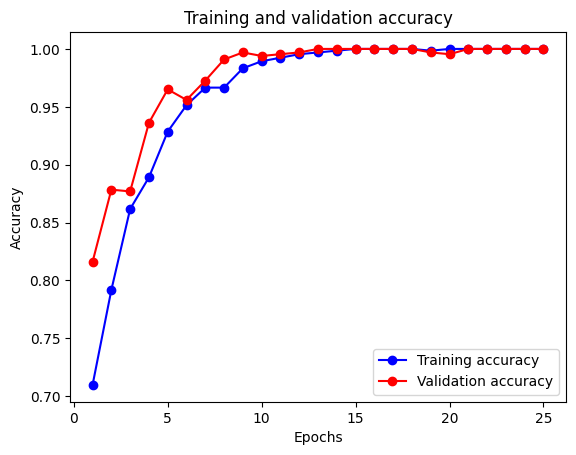

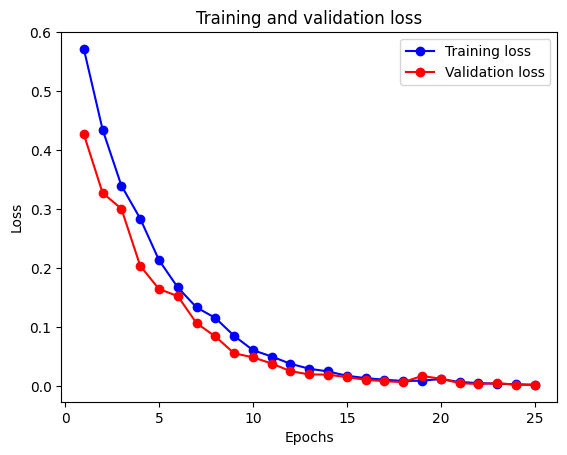

Test Loss: 1.1137800852413333, Test Accuracy: 0.7607361963190185


/home/arnav/anaconda3/envs/research_project/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/arnav/anaconda3/envs/research_project/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Train Loss: 0.6212320518062775, Train Accuracy: 0.6458966565349544, Val Loss: 0.5951501748648035, Val Accuracy: 0.6534954407294833
Epoch 2: Train Loss: 0.5294612137578338, Train Accuracy: 0.7583586626139818, Val Loss: 0.3864467673632036, Val Accuracy: 0.837386018237082
Epoch 3: Train Loss: 0.4616620275809104, Train Accuracy: 0.790273556231003, Val Loss: 0.355099572429815, Val Accuracy: 0.8449848024316109
Epoch 4: Train Loss: 0.42893269343907575, Train Accuracy: 0.8100303951367781, Val Loss: 0.3475064722349845, Val Accuracy: 0.8768996960486323
Epoch 5: Train Loss: 0.3966394692479846, Train Accuracy: 0.8252279635258358, Val Loss: 0.3526777001658836, Val Accuracy: 0.8632218844984803
Epoch 6: Train Loss: 0.34138775975948354, Train Accuracy: 0.8586626139817629, Val Loss: 0.2724066347007202, Val Accuracy: 0.878419452887538
Epoch 7: Train Loss: 0.25410392757011463, Train Accuracy: 0.9103343465045592, Val Loss: 0.20823643227812275, Val Accuracy: 0.9057750759878419
Epoch 8: Train Loss:

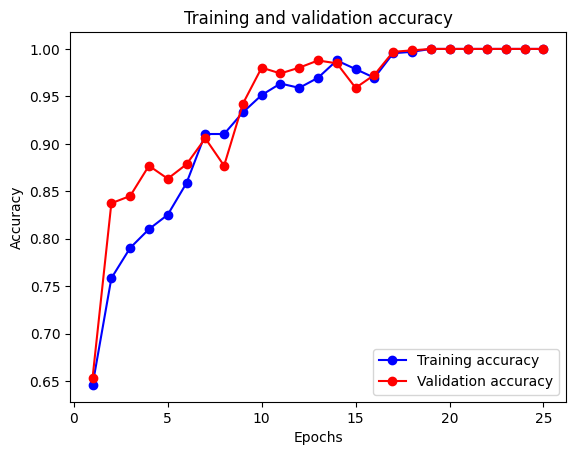

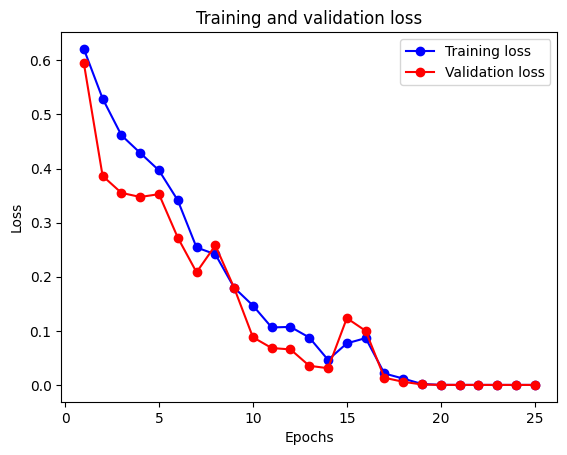

Test Loss: 2.4280003063558007, Test Accuracy: 0.7484662576687117


In [11]:
NN1 = SimpleNN()
optimizer = optim.Adam(NN1.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"

train(NN1, optimizer, loss_fn, train_loader, val_loader, epochs=25, device=device)
test(NN1, test_loader, device=device)

alex_net = CustomAlexNet()
optimizer = optim.Adam(alex_net.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

train(alex_net, optimizer, loss_fn, train_loader, val_loader, epochs=25, device=device)
test(alex_net, test_loader, device=device)


In [12]:
# torch.cuda.memory_summary(device=None, abbreviated=False)

In [13]:
# torch.cuda.empty_cache()

for batch size  = 16

Epoch 1: Train Loss: 0.5500915972959428, Train Accuracy: 0.7021276595744681, Val Loss: 0.40155167292271343, Val Accuracy: 0.8358662613981763
Epoch 2: Train Loss: 0.42066132099855513, Train Accuracy: 0.8085106382978723, Val Loss: 0.343918233755089, Val Accuracy: 0.8556231003039514
Epoch 3: Train Loss: 0.34259569369966075, Train Accuracy: 0.8465045592705167, Val Loss: 0.29717158242350533, Val Accuracy: 0.8966565349544073
Epoch 4: Train Loss: 0.2788391749906753, Train Accuracy: 0.9027355623100304, Val Loss: 0.22414826184865974, Val Accuracy: 0.9240121580547113
Epoch 5: Train Loss: 0.23207376152276993, Train Accuracy: 0.9179331306990881, Val Loss: 0.1788230360973449, Val Accuracy: 0.9498480243161094
Epoch 6: Train Loss: 0.18688638934067317, Train Accuracy: 0.9437689969604863, Val Loss: 0.1535707577353432, Val Accuracy: 0.9680851063829787
Epoch 7: Train Loss: 0.1540684943930024, Train Accuracy: 0.9574468085106383, Val Loss: 0.12469771637448243, Val Accuracy: 0.9741641337386018
Epoch 8: Trai

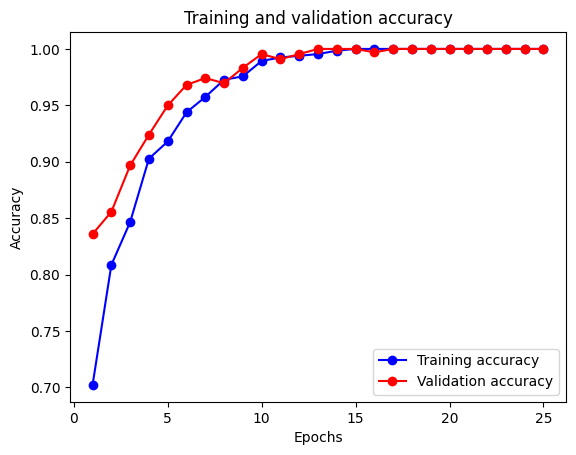

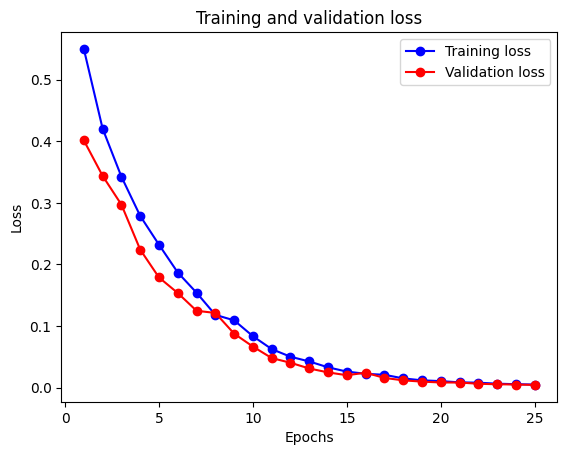

Test Loss: 0.9468648823147471, Test Accuracy: 0.754601226993865
Epoch 1: Train Loss: 0.6550331513086954, Train Accuracy: 0.5851063829787234, Val Loss: 0.5881502415452685, Val Accuracy: 0.7689969604863222
Epoch 2: Train Loss: 0.5574868030491329, Train Accuracy: 0.7188449848024316, Val Loss: 0.43329700118019465, Val Accuracy: 0.8237082066869301
Epoch 3: Train Loss: 0.4337058812379837, Train Accuracy: 0.831306990881459, Val Loss: 0.3506912292823905, Val Accuracy: 0.8419452887537994
Epoch 4: Train Loss: 0.38230155905087787, Train Accuracy: 0.8389057750759878, Val Loss: 0.28464320082483546, Val Accuracy: 0.8829787234042553
Epoch 5: Train Loss: 0.3163696036097549, Train Accuracy: 0.8723404255319149, Val Loss: 0.2841173120874113, Val Accuracy: 0.8814589665653495
Epoch 6: Train Loss: 0.2625700203435762, Train Accuracy: 0.8844984802431611, Val Loss: 0.240858079487918, Val Accuracy: 0.89209726443769
Epoch 7: Train Loss: 0.20220635072993381, Train Accuracy: 0.9331306990881459, Val Loss: 0.1975146

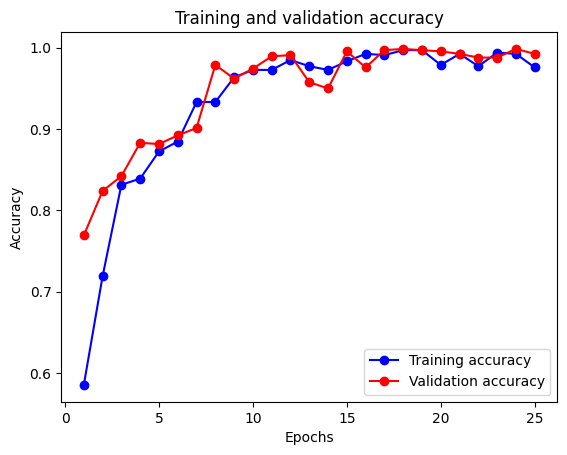

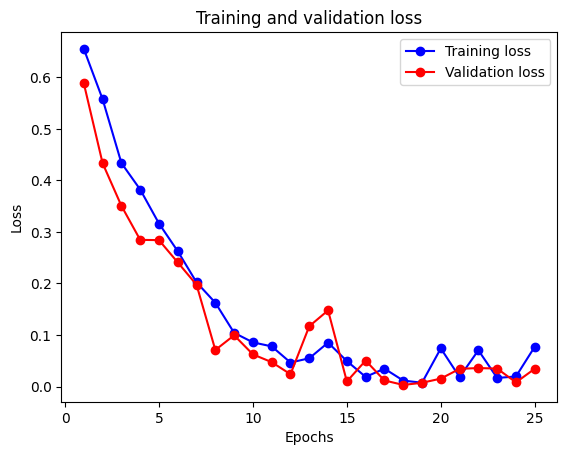

Test Loss: 0.5972506646066904, Test Accuracy: 0.7852760736196319


In [24]:
NN1 = SimpleNN()
optimizer = optim.Adam(NN1.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"

train(NN1, optimizer, loss_fn, train_loader, val_loader, epochs=25, device=device)
test(NN1, test_loader, device=device)

alex_net = CustomAlexNet()
optimizer = optim.Adam(alex_net.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

train(alex_net, optimizer, loss_fn, train_loader, val_loader, epochs=25, device=device)
test(alex_net, test_loader, device=device)


batch size = 32

Epoch 1: Train Loss: 0.5772164393038977, Train Accuracy: 0.682370820668693, Val Loss: 0.45552103434290203, Val Accuracy: 0.7993920972644377
Epoch 2: Train Loss: 0.43811016778151196, Train Accuracy: 0.7978723404255319, Val Loss: 0.37439964002087, Val Accuracy: 0.8465045592705167
Epoch 3: Train Loss: 0.3690120379130046, Train Accuracy: 0.8343465045592705, Val Loss: 0.31094115262939814, Val Accuracy: 0.8875379939209727
Epoch 4: Train Loss: 0.3138423476900373, Train Accuracy: 0.8829787234042553, Val Loss: 0.26939005014442263, Val Accuracy: 0.9164133738601824
Epoch 5: Train Loss: 0.2603344711519423, Train Accuracy: 0.9194528875379939, Val Loss: 0.2202437168785504, Val Accuracy: 0.9376899696048632
Epoch 6: Train Loss: 0.22701275703452883, Train Accuracy: 0.9346504559270516, Val Loss: 0.21536934801510402, Val Accuracy: 0.9331306990881459
Epoch 7: Train Loss: 0.20795964556080954, Train Accuracy: 0.939209726443769, Val Loss: 0.1634967607401666, Val Accuracy: 0.9620060790273556
Epoch 8: Train Lo

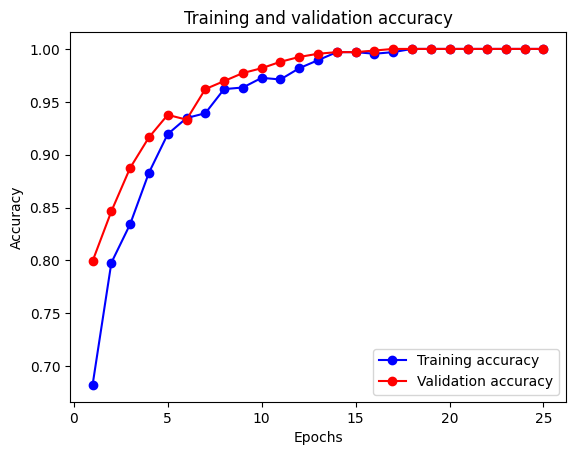

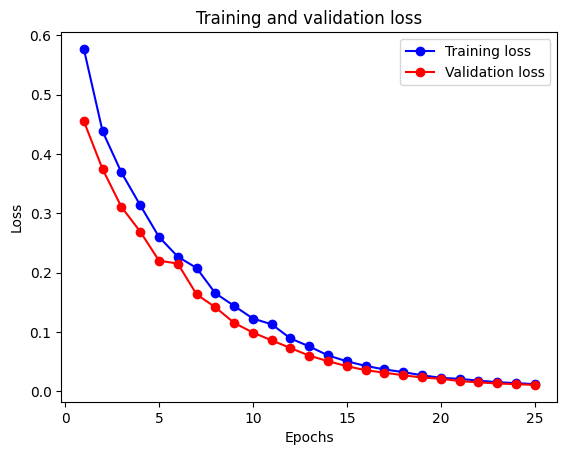

Test Loss: 0.7205296065658331, Test Accuracy: 0.7730061349693251


/home/arnav/anaconda3/envs/research_project/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1: Train Loss: 0.6449333003589085, Train Accuracy: 0.5866261398176292, Val Loss: 0.5892601027375176, Val Accuracy: 0.5866261398176292
Epoch 2: Train Loss: 0.5757682153156826, Train Accuracy: 0.668693009118541, Val Loss: 0.5112850151601291, Val Accuracy: 0.7340425531914894
Epoch 3: Train Loss: 0.4445676789397285, Train Accuracy: 0.7948328267477204, Val Loss: 0.4035139853755633, Val Accuracy: 0.8252279635258358
Epoch 4: Train Loss: 0.47421212991078693, Train Accuracy: 0.756838905775076, Val Loss: 0.3841403765337808, Val Accuracy: 0.8358662613981763
Epoch 5: Train Loss: 0.41181954457646325, Train Accuracy: 0.8100303951367781, Val Loss: 0.3485033469540732, Val Accuracy: 0.8708206686930091
Epoch 6: Train Loss: 0.3357640455166499, Train Accuracy: 0.8571428571428571, Val Loss: 0.27520764902943656, Val Accuracy: 0.8905775075987842
Epoch 7: Train Loss: 0.2611235188586371, Train Accuracy: 0.8890577507598785, Val Loss: 0.20638284477449598, Val Accuracy: 0.9300911854103343
Epoch 8: Train Los

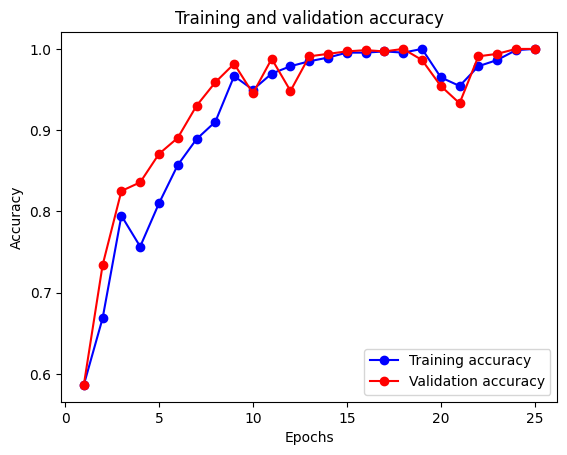

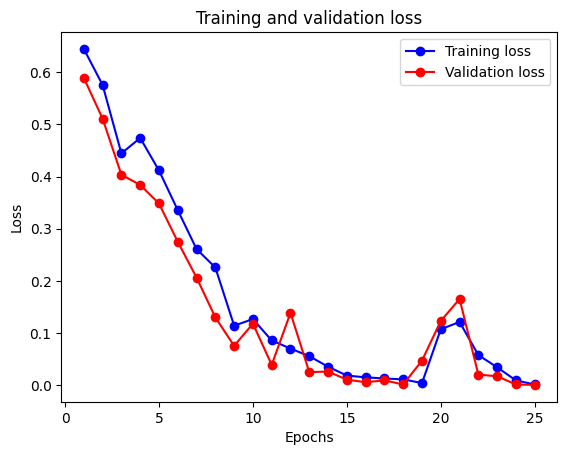

Test Loss: 1.1007516177681584, Test Accuracy: 0.7791411042944786


In [38]:
NN1 = SimpleNN()
optimizer = optim.Adam(NN1.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"

train(NN1, optimizer, loss_fn, train_loader, val_loader, epochs=25, device=device)
test(NN1, test_loader, device=device)

alex_net = CustomAlexNet()
optimizer = optim.Adam(alex_net.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

train(alex_net, optimizer, loss_fn, train_loader, val_loader, epochs=25, device=device)
test(alex_net, test_loader, device=device)


for batch size = 64

Epoch 1: Train Loss: 0.596164882183075, Train Accuracy: 0.6610942249240122, Val Loss: 0.48709863966161554, Val Accuracy: 0.7720364741641338
Epoch 2: Train Loss: 0.4638401107354598, Train Accuracy: 0.8009118541033434, Val Loss: 0.40714257142760535, Val Accuracy: 0.8221884498480243
Epoch 3: Train Loss: 0.4036852771585638, Train Accuracy: 0.8237082066869301, Val Loss: 0.35455084524371405, Val Accuracy: 0.8495440729483282
Epoch 4: Train Loss: 0.363728252324191, Train Accuracy: 0.851063829787234, Val Loss: 0.31789602745663037, Val Accuracy: 0.8601823708206687
Epoch 5: Train Loss: 0.3139243572950363, Train Accuracy: 0.8632218844984803, Val Loss: 0.2804275805299932, Val Accuracy: 0.8996960486322189
Epoch 6: Train Loss: 0.2852285572073676, Train Accuracy: 0.8936170212765957, Val Loss: 0.24519678272984244, Val Accuracy: 0.9148936170212766
Epoch 7: Train Loss: 0.25800948386842554, Train Accuracy: 0.9148936170212766, Val Loss: 0.21752398257905786, Val Accuracy: 0.9407294832826748
Epoch 8: Train L

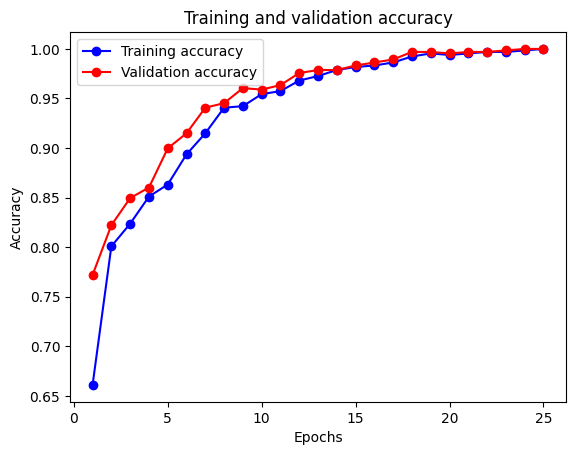

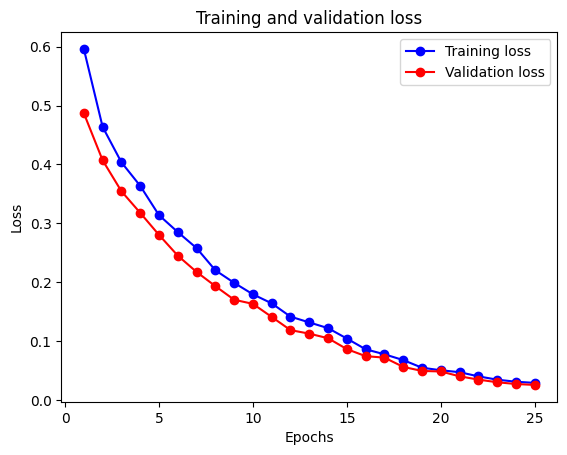

Test Loss: 0.69089209040006, Test Accuracy: 0.7484662576687117
Epoch 1: Train Loss: 0.6334280182014812, Train Accuracy: 0.5851063829787234, Val Loss: 0.5991634130477905, Val Accuracy: 0.5866261398176292
Epoch 2: Train Loss: 0.5789394595406272, Train Accuracy: 0.6945288753799392, Val Loss: 0.48180483417077496, Val Accuracy: 0.8039513677811551
Epoch 3: Train Loss: 0.4742021235552701, Train Accuracy: 0.8039513677811551, Val Loss: 0.44132606211033737, Val Accuracy: 0.7963525835866262
Epoch 4: Train Loss: 0.4478383172642101, Train Accuracy: 0.776595744680851, Val Loss: 0.6411373432387005, Val Accuracy: 0.6869300911854104
Epoch 5: Train Loss: 0.4615427282723514, Train Accuracy: 0.7735562310030395, Val Loss: 0.3968344168229537, Val Accuracy: 0.851063829787234
Epoch 6: Train Loss: 0.3755637353116816, Train Accuracy: 0.8343465045592705, Val Loss: 0.3220700201663104, Val Accuracy: 0.8647416413373861
Epoch 7: Train Loss: 0.31718896329402924, Train Accuracy: 0.8525835866261399, Val Loss: 0.3703440

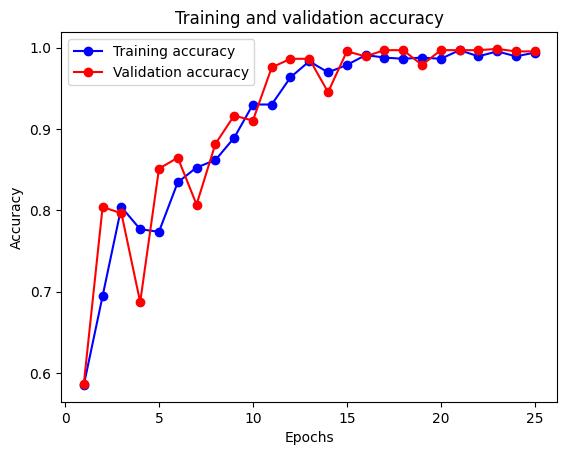

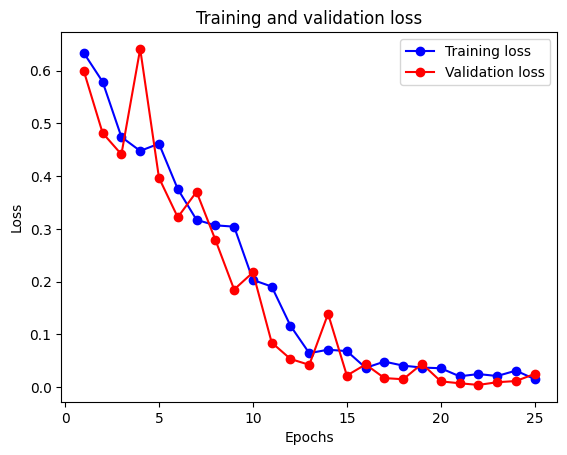

Test Loss: 1.1653346419334412, Test Accuracy: 0.7668711656441718


In [42]:
NN1 = SimpleNN()
optimizer = optim.Adam(NN1.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"

train(NN1, optimizer, loss_fn, train_loader, val_loader, epochs=25, device=device)
test(NN1, test_loader, device=device)

alex_net = CustomAlexNet()
optimizer = optim.Adam(alex_net.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

train(alex_net, optimizer, loss_fn, train_loader, val_loader, epochs=25, device=device)
test(alex_net, test_loader, device=device)


for batch size = 128

Epoch 1: Train Loss: 0.6072780589262644, Train Accuracy: 0.6109422492401215, Val Loss: 0.5175320853789648, Val Accuracy: 0.7507598784194529
Epoch 2: Train Loss: 0.502799779176712, Train Accuracy: 0.7477203647416414, Val Loss: 0.4497796297073364, Val Accuracy: 0.7750759878419453
Epoch 3: Train Loss: 0.46223058303197223, Train Accuracy: 0.7857142857142857, Val Loss: 0.4044228196144104, Val Accuracy: 0.8221884498480243
Epoch 4: Train Loss: 0.39906203250090283, Train Accuracy: 0.8297872340425532, Val Loss: 0.3682927389939626, Val Accuracy: 0.8419452887537994
Epoch 5: Train Loss: 0.40088024735450745, Train Accuracy: 0.8465045592705167, Val Loss: 0.33913157880306244, Val Accuracy: 0.8662613981762918
Epoch 6: Train Loss: 0.3540032108624776, Train Accuracy: 0.8693009118541033, Val Loss: 0.31325800468524295, Val Accuracy: 0.8905775075987842
Epoch 7: Train Loss: 0.31405216952164966, Train Accuracy: 0.8829787234042553, Val Loss: 0.2897777607043584, Val Accuracy: 0.9027355623100304
Epoch 8: Train 

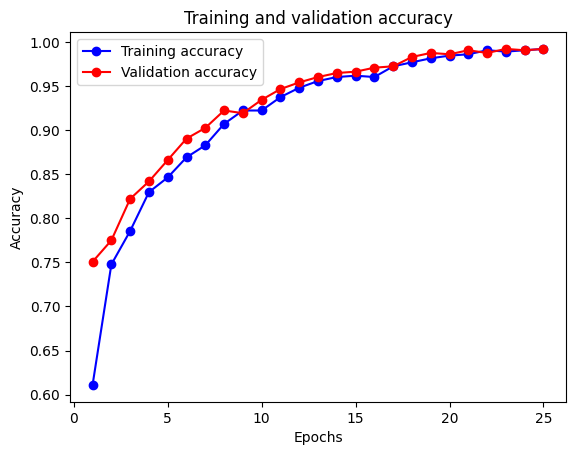

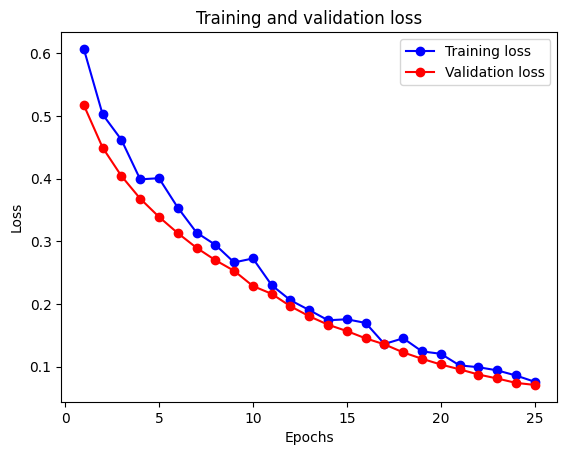

Test Loss: 0.5470781922340393, Test Accuracy: 0.754601226993865
Epoch 1: Train Loss: 0.677341898282369, Train Accuracy: 0.5486322188449848, Val Loss: 0.6459940075874329, Val Accuracy: 0.5866261398176292
Epoch 2: Train Loss: 0.6626587808132172, Train Accuracy: 0.5866261398176292, Val Loss: 0.5631178915500641, Val Accuracy: 0.5866261398176292
Epoch 3: Train Loss: 0.5922536551952362, Train Accuracy: 0.5866261398176292, Val Loss: 0.5209000284473101, Val Accuracy: 0.5866261398176292
Epoch 4: Train Loss: 0.5785456001758575, Train Accuracy: 0.6747720364741642, Val Loss: 0.502416064341863, Val Accuracy: 0.8069908814589666
Epoch 5: Train Loss: 0.513885940114657, Train Accuracy: 0.8054711246200608, Val Loss: 0.4321296960115433, Val Accuracy: 0.8191489361702128
Epoch 6: Train Loss: 0.4310399244228999, Train Accuracy: 0.8054711246200608, Val Loss: 0.37777206177512807, Val Accuracy: 0.8297872340425532
Epoch 7: Train Loss: 0.40563590327898663, Train Accuracy: 0.8282674772036475, Val Loss: 0.40518424

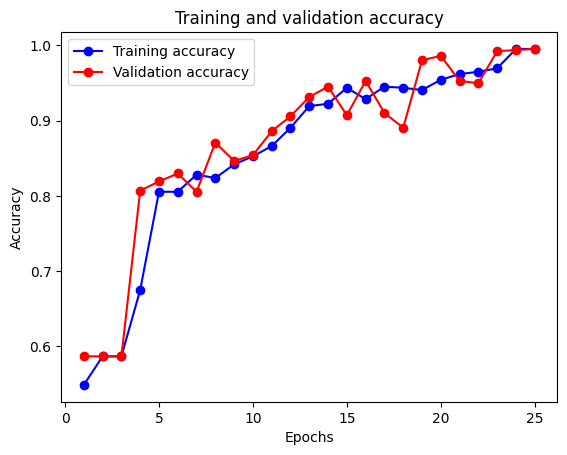

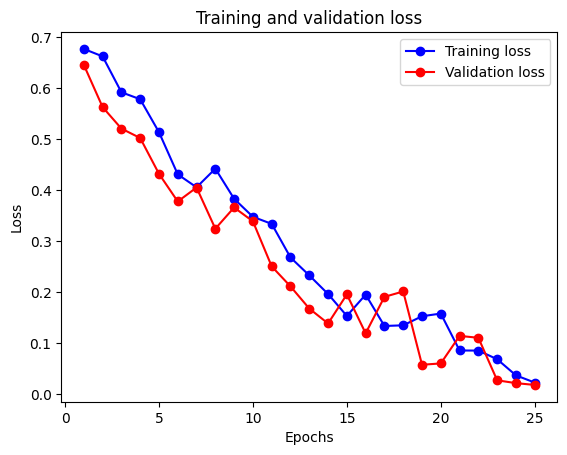

Test Loss: 0.6599115431308746, Test Accuracy: 0.8098159509202454


In [46]:
NN1 = SimpleNN()
optimizer = optim.Adam(NN1.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"

train(NN1, optimizer, loss_fn, train_loader, val_loader, epochs=25, device=device)
test(NN1, test_loader, device=device)

alex_net = CustomAlexNet()
optimizer = optim.Adam(alex_net.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

train(alex_net, optimizer, loss_fn, train_loader, val_loader, epochs=25, device=device)
test(alex_net, test_loader, device=device)
